In [106]:
import cv2
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
from cv2 import aruco
import matplotlib.pyplot as plt
import os
import polars as pl
import toml
import sys
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.pd_support import *

from datetime import datetime
from support.pd_support import *
from support.ar_calculations import *
from scipy.spatial.transform import Rotation as R

In [107]:
_base_pth = os.path.join(os.getcwd(), "recordings")
_folder_name = "skate_cwide_random"
_video_pth = os.path.join(_base_pth, _folder_name, "webcam_color.msgpack")
_timestamp_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")

In [108]:
calib_data = toml.load("calib_wide2.toml")
camera_mat = np.array(calib_data["calibration"]["camera_matrix"]).reshape((3, 3))
dist_coef = np.array(calib_data["calibration"]["dist_coeffs"])

In [109]:
camera_mat

array([[816.816261  ,   0.        , 848.36872482],
       [  0.        , 822.75819761, 639.03437395],
       [  0.        ,   0.        ,   1.        ]])

In [110]:
with open(_timestamp_pth, "rb") as f:
    timestamps = list(mp.Unpacker(f, object_hook=mpn.decode))

with open(_video_pth, "rb") as f:
    video_data = list(mp.Unpacker(f, object_hook=mpn.decode))

_time = [
    datetime.strptime(_t, "%Y-%m-%d %H:%M:%S.%f") for _t in np.array(timestamps)[:, 1]
]

_sync = np.array(timestamps)[:, 0].astype(bool)

In [111]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)


def estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(
            marker_points, c, mtx, distortion, True, flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()

        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [112]:
data = {"frame_id": [], "marker_ids": [], "corners": [], "tvec": [], "rvec": []}
counter = 0

for _frame in tqdm(video_data[1:]):
    # _frame = cv2.cvtColor(_frame,cv2.COLOR_RGBA2GRAY)
    # corners, ids, rejected_image_points = detector.detectMarkers(_frame)
    # corners, ids, _, _ = detector.refineDetectedMarkers(
    #     image=_frame,
    #     board=board,
    #     detectedCorners=corners,
    #     detectedIds=ids,
    #     rejectedCorners=rejected_image_points,
    #     cameraMatrix=camera_mat,
    #     distCoeffs=dist_coef,
    # )
    corners, ids = _frame

    if ids is None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(None)
        data["corners"].append(None)
        data["tvec"].append(None)
        data["rvec"].append(None)

    if ids is not None:
        rvec, tvec = estimatePoseSingleMarkers(
            corners=corners,
            marker_size=0.05,
            mtx=camera_mat,
            distortion=dist_coef,
        )
        data["frame_id"].append(counter)
        data["marker_ids"].append(ids)
        data["corners"].append(corners)
        data["tvec"].append(tvec)
        data["rvec"].append(rvec)
    counter += 1
    

100%|██████████| 1125/1125 [00:00<00:00, 6883.22it/s]


In [113]:
default_ids = [12, 14, 20, 88, 89]
coordinate = {
    str(id): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []}
    for id in default_ids
}

for i, frame_id in enumerate(data["frame_id"]):
    if data["marker_ids"][i] is not None:
        existing_ids = set(data["marker_ids"][i].reshape(-1))
        missing_ids = set(default_ids) - existing_ids

        for _m, tvec, rvec in zip(
            data["marker_ids"][i], data["tvec"][i], data["rvec"][i]
        ):
            if _m in default_ids:
                coord = coordinate[str(_m[0])]
                coord["x"].append(tvec[0][0])
                coord["y"].append(tvec[0][1])
                coord["z"].append(tvec[0][2])
                coord["rx"].append(rvec[0][0])
                coord["ry"].append(rvec[0][1])
                coord["rz"].append(rvec[0][2])

        for _m in missing_ids:
            coord = coordinate[str(_m)]
            coord["x"].append(np.nan)
            coord["y"].append(np.nan)
            coord["z"].append(np.nan)
            coord["rx"].append(np.nan)
            coord["ry"].append(np.nan)
            coord["rz"].append(np.nan)
    else:
        for _m in default_ids:
            coord = coordinate[str(_m)]
            coord["x"].append(np.nan)
            coord["y"].append(np.nan)
            coord["z"].append(np.nan)
            coord["rx"].append(np.nan)
            coord["ry"].append(np.nan)
            coord["rz"].append(np.nan)

In [114]:
ar_df = pl.from_dicts(coordinate["88"])
rvec = ar_df[["rx", "ry", "rz"]][0].to_numpy()
ar_rotmat = cv2.Rodrigues(rvec)[0]

tar = ar_rotmat.T @ (
    ar_df[["x", "y", "z"]].to_numpy().T - ar_df[["x", "y", "z"]][0].to_numpy().T
)
_ar_df = pl.from_dicts({"time": _time, "x": tar[0], "y": tar[1], "z": tar[2]})

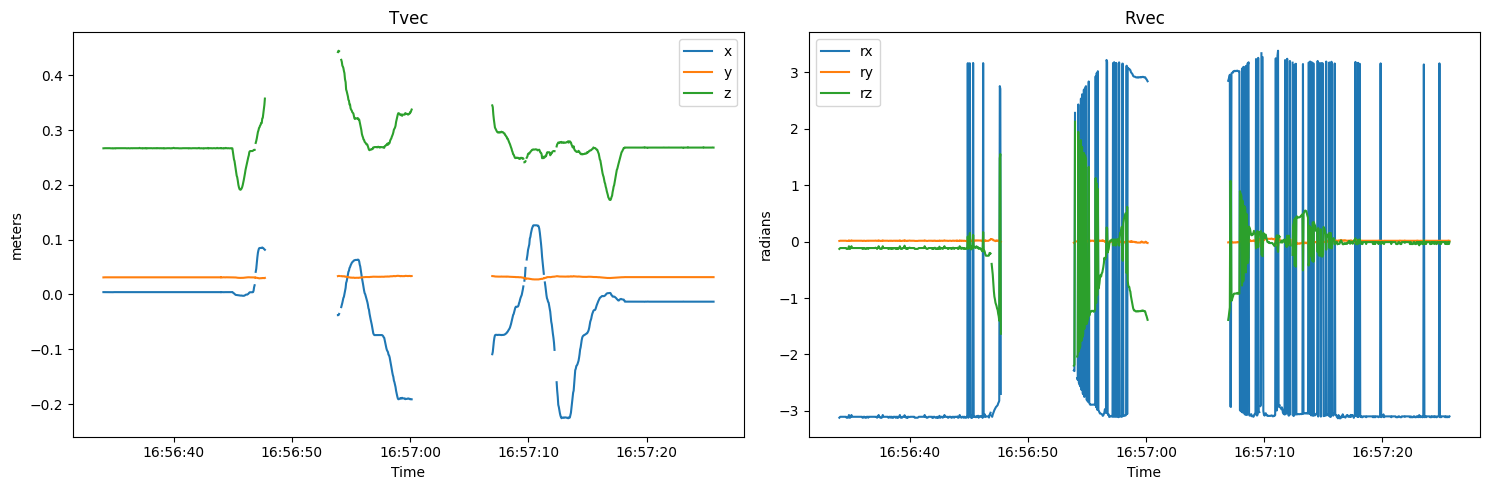

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(_ar_df["time"], coordinate['88']["x"], label="x")
ax1.plot(_ar_df["time"], coordinate['88']["y"], label="y")
ax1.plot(_ar_df["time"], coordinate['88']["z"], label="z")
ax1.set_title("Tvec")
ax1.set_ylabel('meters')
ax1.set_xlabel('Time')
ax1.legend()
ax2.plot(_ar_df["time"], coordinate["88"]["rx"], label="rx")
ax2.plot(_ar_df["time"], coordinate["88"]["ry"], label="ry")
ax2.plot(_ar_df["time"], coordinate["88"]["rz"], label="rz")
ax2.set_title("Rvec")
ax2.set_ylabel('radians')
ax2.set_xlabel('Time')
ax2.legend()
plt.tight_layout()
plt.show()


In [116]:
coordinate['89']['x'] = coordinate['89']['x'][:len(_ar_df['time'])]
coordinate['89']['y'] = coordinate['89']['y'][:len(_ar_df['time'])]
coordinate['89']['z'] = coordinate['89']['z'][:len(_ar_df['time'])]
coordinate['89']['rx'] = coordinate['89']['rx'][:len(_ar_df['time'])]
coordinate['89']['ry'] = coordinate['89']['ry'][:len(_ar_df['time'])]
coordinate['89']['rz'] = coordinate['89']['rz'][:len(_ar_df['time'])]

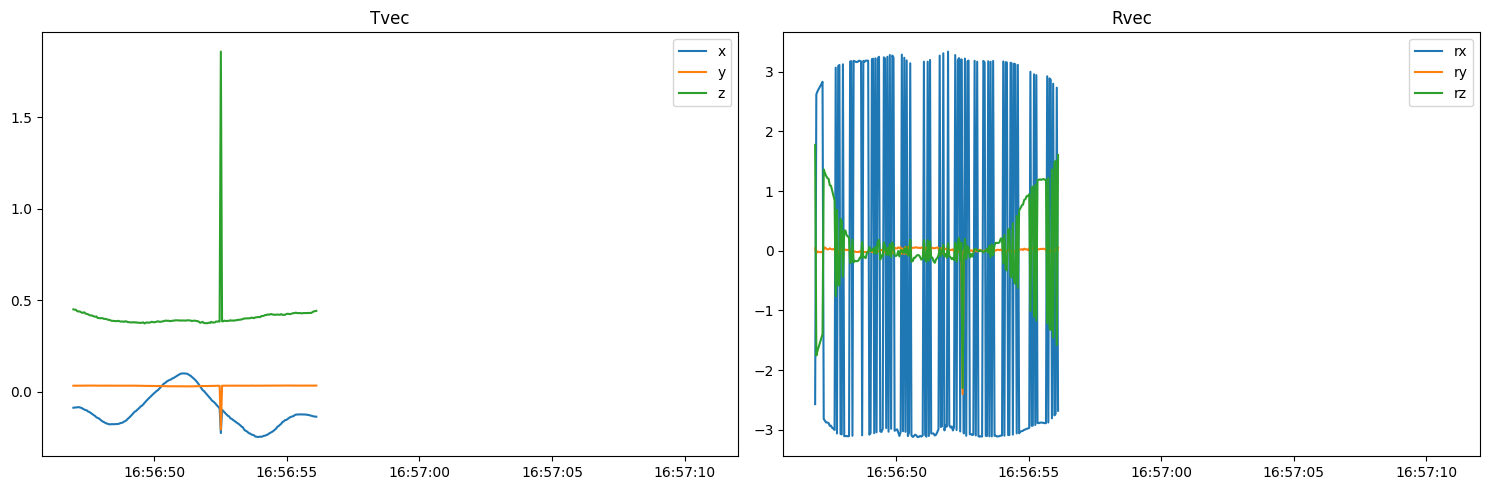

In [117]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(_ar_df["time"], coordinate['89']["x"], label="x")
ax1.plot(_ar_df["time"], coordinate['89']["y"], label="y")
ax1.plot(_ar_df["time"], coordinate['89']["z"], label="z")
ax1.set_title("Tvec")
ax1.legend()
ax2.plot(_ar_df["time"], coordinate["89"]["rx"], label="rx")
ax2.plot(_ar_df["time"], coordinate["89"]["ry"], label="ry")
ax2.plot(_ar_df["time"], coordinate["89"]["rz"], label="rz")
ax2.set_title("Rvec")
ax2.legend()
plt.tight_layout()
plt.show()


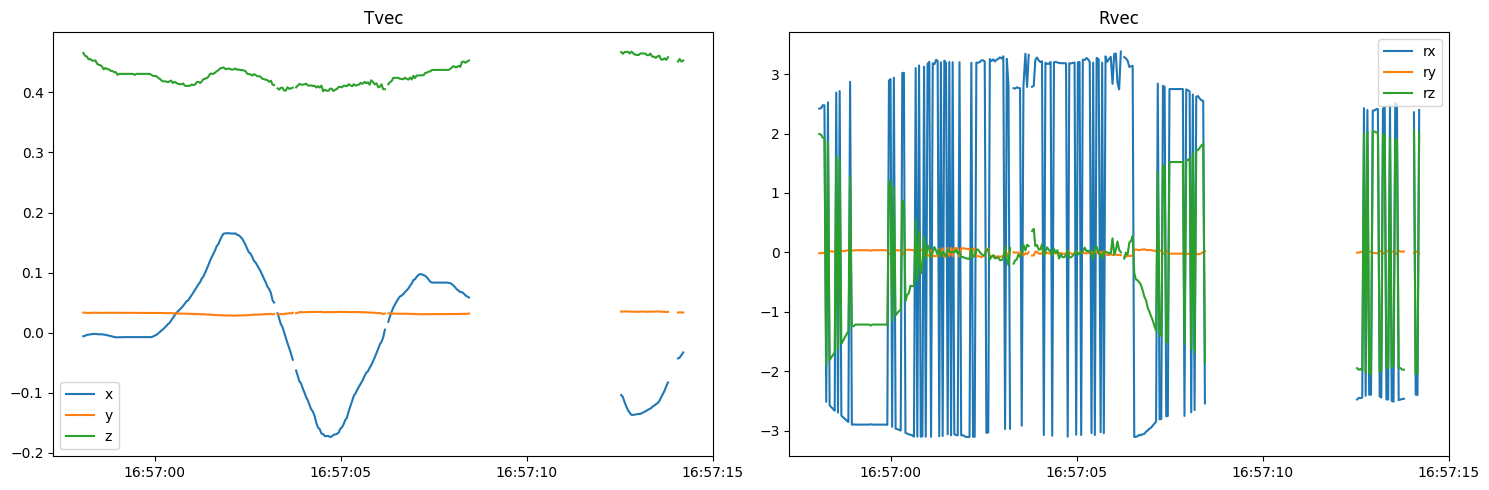

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(_ar_df["time"], coordinate['12']["x"], label="x")
ax1.plot(_ar_df["time"], coordinate['12']["y"], label="y")
ax1.plot(_ar_df["time"], coordinate['12']["z"], label="z")
ax1.set_title("Tvec")
ax1.legend()
ax2.plot(_ar_df["time"], coordinate["12"]["rx"], label="rx")
ax2.plot(_ar_df["time"], coordinate["12"]["ry"], label="ry")
ax2.plot(_ar_df["time"], coordinate["12"]["rz"], label="rz")
ax2.set_title("Rvec")
ax2.legend()
plt.tight_layout()
plt.show()


In [119]:
# Define offsets

offsets = {
    12: np.array([-0.05, 0.03, -0.055]),
    14: np.array([0.00, 0.1025, -0.069]),
    20: np.array([0.00, 0.01, -0.069]),
    88: np.array([0.00, 0.03, -0.11]),
    89: np.array([0.05, 0.03, -0.055]),
}

offsets = {
    12: np.array([-0.09, 0.0, -0.069]),
    14: np.array([0.00, 0.1025, -0.069]),
    20: np.array([0.00, 0.01, -0.069]),
    88: np.array([0.00, 0.0, -0.1075]),
    89: np.array([0.1, 0.0, -0.069]),
}
# offsets = {
#     12: np.array([-0.09, 0.0, -0.069]),
#     14: np.array([0.00, 0.1025, -0.069]),
#     20: np.array([0.00, 0.01, -0.069]),
#     88: np.array([0.00502513, -0.034     , -0.08237437]),
#     89: np.array([0.1, 0.0, -0.055]),
# }


# Function to compute transformed coordinates
def compute_transformed_coordinates(coordinate, id_offset):
    rotation_matrix = R.from_rotvec(
        np.array([coordinate["rx"], coordinate["ry"], coordinate["rz"]]).T
    ).as_matrix()
    translation_vector = np.array([coordinate["x"], coordinate["y"], coordinate["z"]])
    transformed = np.array(
        [
            (_r @ id_offset.reshape(3, 1) + _t.reshape(3, 1)).T[0]
            for _r, _t in zip(rotation_matrix, translation_vector.T)
        ]
    )
    return rotation_matrix, translation_vector, transformed


# Compute transformations
results = {}
for key in offsets.keys():
    results[key] = compute_transformed_coordinates(coordinate[str(key)], offsets[key])

# Transform to global coordinates
_r_88_inv = results[88][0][5].T
_tvec_88_0 = results[88][2][0]

world_coordinates = {}
for key in offsets.keys():
    world_coordinates[key] = _r_88_inv @ (results[key][2] - _tvec_88_0).T

_gt_12, _gt_14, _gt_20, _gt_88, _gt_89 = [
    world_coordinates[key] for key in [12, 14, 20, 88, 89]
]
_gt_89[2] = _gt_89[2] + 0.01
_gt_12[2] = _gt_12[2] + 0.01
_mean_val = np.nanmean([_gt_12, _gt_14, _gt_20, _gt_88, _gt_89], axis=0)
# _mean_val = np.nanmean([ _gt_88], axis=0)

C:\Users\Pintu\AppData\Local\Temp\ipykernel_67888\110531168.py:60: RuntimeWarning: Mean of empty slice
  _mean_val = np.nanmean([_gt_12, _gt_14, _gt_20, _gt_88, _gt_89], axis=0)


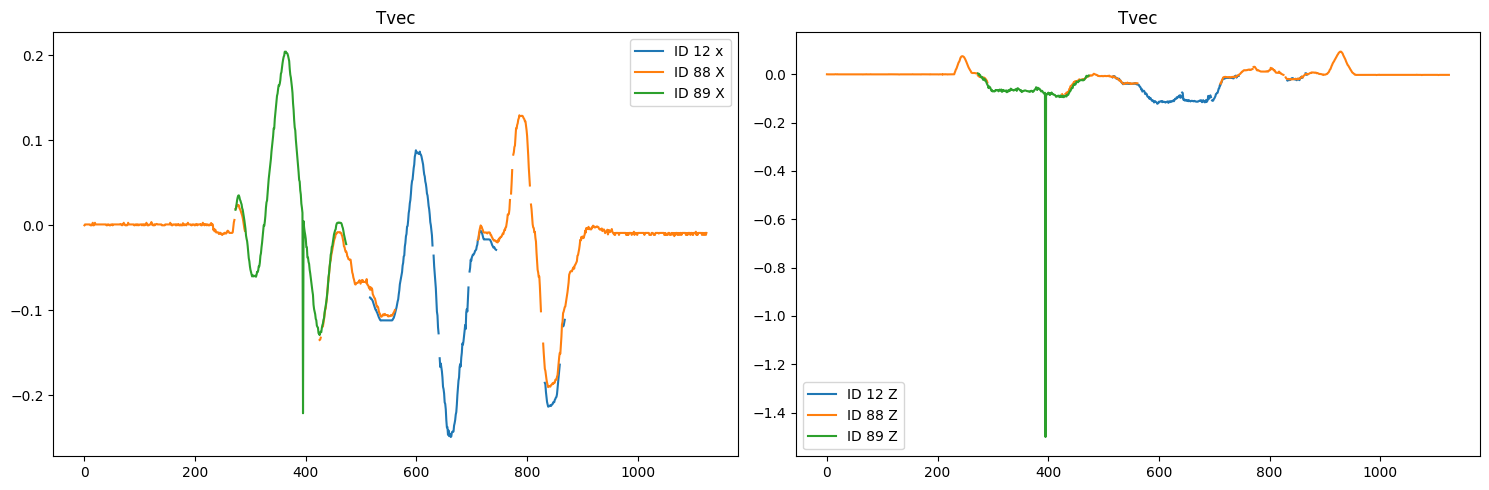

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(_gt_12[0], label="ID 12 x")
ax1.plot(_gt_88[0], label="ID 88 X")
ax1.plot(_gt_89[0], label="ID 89 X")
ax1.set_title("Tvec")
ax1.legend()
ax2.plot(_gt_12[2], label="ID 12 Z")
ax2.plot(_gt_88[2], label="ID 88 Z")
ax2.plot(_gt_89[2], label="ID 89 Z")
ax2.set_title("Tvec")
ax2.legend()
plt.tight_layout()
plt.show()


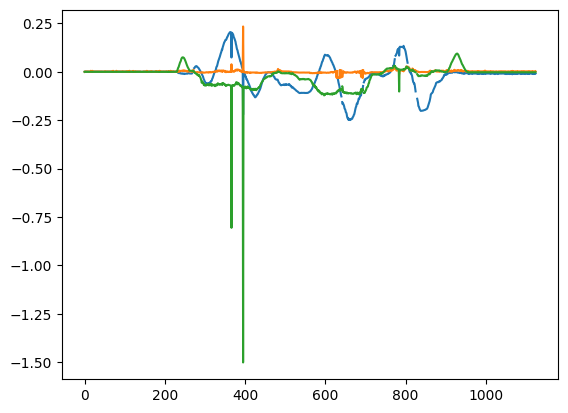

In [121]:
plt.plot(_mean_val[0])
plt.plot(_mean_val[1])
plt.plot(_mean_val[2])
# plt.ylim(-0.01, 0.01)

In [122]:
start_idx = list(_sync).index(1)
end_idx = start_idx + list(_sync[start_idx:]).index(0)
sync = _sync[start_idx:end_idx]
time = _time[start_idx:end_idx]
sync_start_time = time[0]
sync_end_time = time[-1]

_mocap_pth = os.path.join(_base_pth, 'mocap', _folder_name + '.csv')
mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
mocap_df = add_datetime_col(mocap_df, st_time, "seconds")
mocap_df = pl.from_pandas(mocap_df)

_mean_val = _mean_val.T[start_idx:end_idx]

_mocap_quat = R.from_quat(
    mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]][0].to_numpy()
)
_mocap_mat = _mocap_quat.as_matrix()[0]
_time_offset = sync_start_time - mocap_df["time"][0]
mocap_df = mocap_df.with_columns([(pl.col("time") + _time_offset).alias("time")])

e:\CMC\pyprojects\DeepVision\wearable\..\support\pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [123]:
_m = get_rb_marker_name(3)
_m_org = mocap_df[[_m["x"], _m["y"], _m["z"]]][0].to_numpy().T
_m_tvec = mocap_df[[_m["x"], _m["y"], _m["z"]]].to_numpy().T
_m_transformed = _mocap_mat.T @ (_m_tvec - _m_org)
_mean_val = _mean_val.T

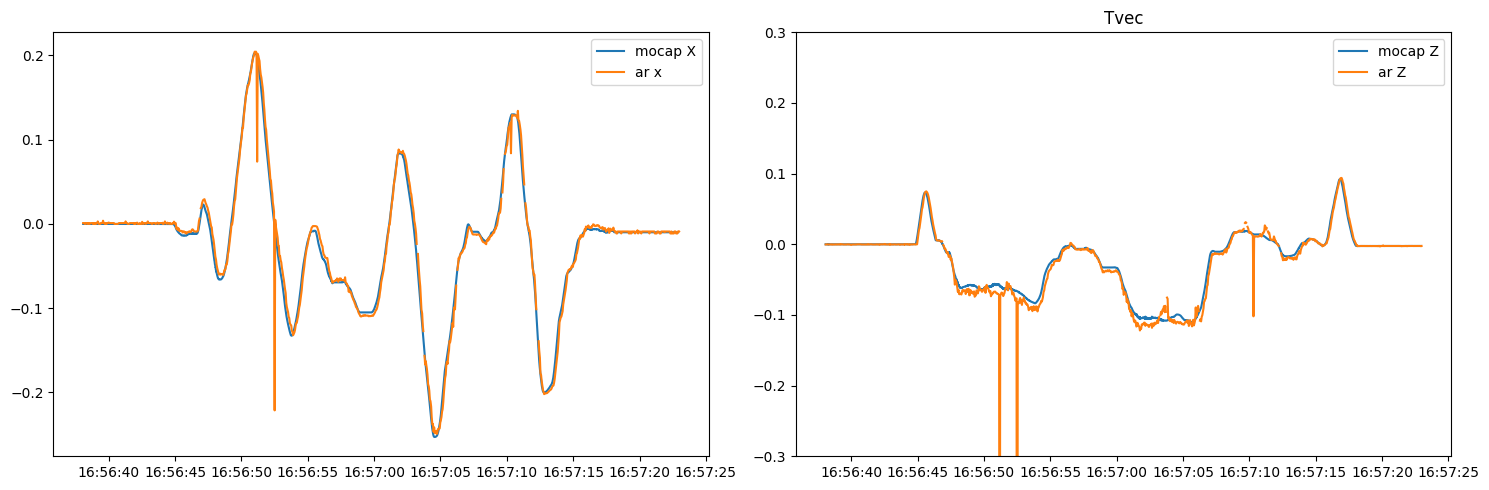

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(mocap_df["time"], _m_transformed[0], label="mocap X")
ax1.plot(time, _mean_val[0], label="ar x")
# ax1.plot(_ar_df['time'], _ar_df['x'], label="ar x")
ax1.legend()
ax2.plot(mocap_df["time"], _m_transformed[2], label="mocap Z")
ax2.plot(time, _mean_val[2], label="ar Z")
ax2.set_ylim(-0.3, 0.3)
# ax2.plot(_ar_df['time'], _ar_df['z'], label="ar Z")
ax2.set_title("Tvec")
ax2.legend()
plt.tight_layout()
plt.show()


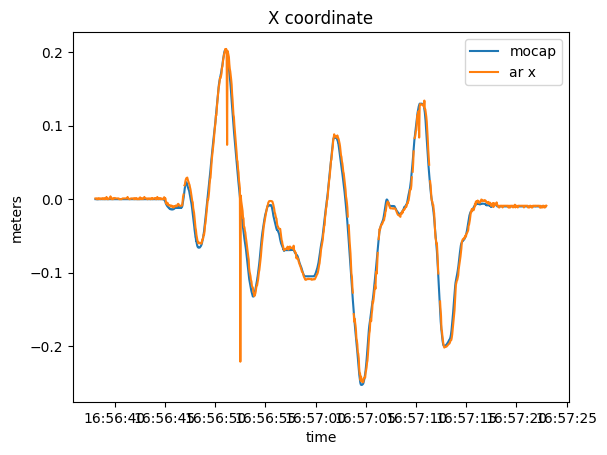

In [125]:
plt.plot(mocap_df["time"], _m_transformed[0], label="mocap")
plt.plot(time, _mean_val[0], label="ar x")
plt.xlabel("time")
plt.ylabel("meters")
plt.title("X coordinate")
plt.legend()

In [134]:
from scipy import stats

ar_df = pl.from_dict(
    {"time": time, "x": _mean_val[0], "y": _mean_val[1], "z": _mean_val[2]}
)

f1 = interp1d(ar_df["time"].dt.epoch(), ar_df["x"], fill_value="extrapolate")
f2 = interp1d(ar_df["time"].dt.epoch(), ar_df["y"], fill_value="extrapolate")
f3 = interp1d(ar_df["time"].dt.epoch(), ar_df["z"], fill_value="extrapolate")

_ar_x = f1(mocap_df["time"].dt.epoch())
_ar_y = f2(mocap_df["time"].dt.epoch())
_ar_z = f3(mocap_df["time"].dt.epoch())

_err_x = _m_transformed[0] - _ar_x
_err_y = _m_transformed[1] - _ar_y
_err_z = _m_transformed[2] - _ar_z


zscore_x = np.abs(stats.zscore(_err_x, nan_policy="omit"))
zscore_y = np.abs(stats.zscore(_err_y, nan_policy="omit"))
zscore_z = np.abs(stats.zscore(_err_z, nan_policy="omit"))
_zerr_x = _err_x[np.where(zscore_x < 2)]
_zerr_y = _err_y[np.where(zscore_y < 2)]
_zerr_z = _err_z[np.where(zscore_z < 2)]

In [135]:
max(abs(_zerr_z))

0.08087531927685843

In [131]:
np.mean(abs(_zerr_x)), np.mean(_zerr_y), np.mean(abs(_zerr_z))

(0.004972255261302487, -0.0005264271770296176, 0.004561563965187853)

In [128]:
print("mean", np.nanmean(_zerr_x), np.nanmean(_zerr_y), np.nanmean(_zerr_z))
print("median", np.nanmedian(_zerr_x), np.nanmedian(_zerr_y), np.nanmedian(_zerr_z))
print("max", np.nanmax(_zerr_x), np.nanmax(_zerr_y), np.nanmax(_zerr_z))

mean -0.0011881316259210045 -0.0005264271770296176 0.002951539321194214
median -0.0009135420267409331 -0.0006706775530411173 0.0012007777524324454
max 0.0240906044589433 0.024578174247316748 0.1252694424814904
